In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib
import pandas as pd
import pathlib
import math

from utils import model_shortname

# remove limits for rows and cols in dataframe listing
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

Using TensorFlow backend.


# Input

In [2]:
# metrics_df.to_feather("./metrics_df.feather")
metrics_df = pd.read_feather("./metrics_df.feather")
# !rm metrics_df.feather
!ls - lh * .feather

-rw-rw-r-- 1 tiagonb tiagonb 192K mar 26 05:12 metrics_df.feather
-rw-rw-r-- 1 tiagonb tiagonb  75M mar 17 21:45 predictions_all_info.feather
-rw-rw-r-- 1 tiagonb tiagonb 6,3M mar  9 13:57 predictions_clusters.feather
-rw-rw-r-- 1 tiagonb tiagonb 581K fev 26 12:34 predictions.feather
-rw-rw-r-- 1 tiagonb tiagonb 7,3M mar  5 12:23 predictions_testing_set.feather
-rw-rw-r-- 1 tiagonb tiagonb  17M mar  9 10:37 predictions_training_set.feather
-rw-rw-r-- 1 tiagonb tiagonb 7,9M mar  5 12:24 predictions_validation_set.feather
-rw-rw-r-- 1 tiagonb tiagonb 3,6M fev 19 04:36 processed_df.feather


In [27]:
def add_metrics(metrics_df):
    # Sensitivity, hit rate, recall, or true positive rate: TPR = TP/(TP+FN)
    # if numerator == zero, return zero (to avoid division by zero exception)
    metrics_df['tpr_ncp'] = metrics_df.apply(lambda row: 0.0 if row['tp_ncp'] == 0 else
                                             float(row['tp_ncp']) / (row['tp_ncp'] + row['fn_ncp']), axis=1)
    metrics_df['tpr_cp'] = metrics_df.apply(lambda row: 0.0 if row['tp_cp'] == 0 else
                                            float(row['tp_cp']) / (row['tp_cp'] + row['fn_cp']), axis=1)
    metrics_df['tpr_normal'] = metrics_df.apply(lambda row: 0.0 if row['tp_normal'] == 0 else
                                                float(
                                                    row['tp_normal']) / (row['tp_normal'] + row['fn_normal']),
                                                axis=1)
    metrics_df['tpr_macro'] = metrics_df.apply(lambda row: float(
        row['tpr_ncp'] + row['tpr_cp'] + row['tpr_normal']) / 3, axis=1)
    metrics_df['tpr_micro'] = metrics_df.apply(lambda row: 0.0 if (row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) == 0 else
                                               float(row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) /
                                               (row['tp_ncp'] + row['tp_cp'] + row['tp_normal'] + row['fn_ncp'] +
                                               row['fn_cp'] + row['fn_normal']), axis=1)

    # Specificity or true negative rate: TNR = TN/(TN+FP)
    metrics_df['tnr_ncp'] = metrics_df.apply(lambda row: 0.0 if row['tn_ncp'] == 0 else
                                             float(row['tn_ncp']) / (row['tn_ncp'] + row['fp_ncp']), axis=1)
    metrics_df['tnr_cp'] = metrics_df.apply(lambda row: 0.0 if row['tn_cp'] == 0 else
                                            float(row['tn_cp']) / (row['tn_cp'] + row['fp_cp']), axis=1)
    metrics_df['tnr_normal'] = metrics_df.apply(lambda row: 0.0 if row['tn_normal'] == 0 else
                                                float(
                                                    row['tn_normal']) / (row['tn_normal'] + row['fp_normal']),
                                                axis=1)
    metrics_df['tnr_macro'] = metrics_df.apply(lambda row: float(
        row['tnr_ncp'] + row['tnr_cp'] + row['tnr_normal']) / 3, axis=1)
    metrics_df['tnr_micro'] = metrics_df.apply(lambda row: 0.0 if (row['tn_ncp'] + row['tn_cp'] + row['tn_normal']) == 0 else
                                               float(row['tn_ncp'] + row['tn_cp'] + row['tn_normal']) /
                                               (row['tn_ncp'] + row['tn_cp'] + row['tn_normal'] + row['fn_ncp'] +
                                               row['fn_cp'] + row['fn_normal']), axis=1)

    # Precision or positive predictive value: PPV = TP/(TP+FP)
    metrics_df['ppv_ncp'] = metrics_df.apply(lambda row: 0.0 if row['tp_ncp'] == 0 else
                                             float(row['tp_ncp']) / (row['tp_ncp'] + row['fp_ncp']), axis=1)
    metrics_df['ppv_cp'] = metrics_df.apply(lambda row: 0.0 if row['tp_cp'] == 0 else
                                            float(row['tp_cp']) / (row['tp_cp'] + row['fp_cp']), axis=1)
    metrics_df['ppv_normal'] = metrics_df.apply(lambda row: 0.0 if row['tp_normal'] == 0 else
                                                float(
                                                    row['tp_normal']) / (row['tp_normal'] + row['fp_normal']),
                                                axis=1)
    metrics_df['ppv_macro'] = metrics_df.apply(lambda row: float(
        row['ppv_ncp'] + row['ppv_cp'] + row['ppv_normal']) / 3, axis=1)
    metrics_df['ppv_micro'] = metrics_df.apply(lambda row: 0.0 if (row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) == 0 else
                                               float(row['tp_ncp'] + row['tp_cp'] + row['tp_normal']) /
                                               (row['tp_ncp'] + row['tp_cp'] + row['tp_normal'] + row['fp_ncp'] +
                                               row['fp_cp'] + row['fp_normal']), axis=1)

    metrics_df['fpr_ncp'] = 1 - metrics_df['tnr_ncp']
    metrics_df['fpr_cp'] = 1 - metrics_df['tnr_cp']
    metrics_df['fpr_normal'] = 1 - metrics_df['tnr_normal']
    metrics_df['fpr_macro'] = 1 - metrics_df['tnr_macro']
    metrics_df['fpr_micro'] = 1 - metrics_df['tnr_micro']

    # points distances from (0, 1) in ROC space, the min distance will be considerated best classification
    metrics_df['dist'] = ((metrics_df['fpr_micro'] - 0) **
                          2 + (metrics_df['tpr_micro'] - 1)**2)**(0.5)
    # Negative predictive value: NPV = TN/(TN+FN)
    # Fall out or false positive rate: FPR = FP/(FP+TN)
    # False negative rate: FNR = FN/(TP+FN)
    # False discovery rate: FDR = FP/(TP+FP)
    return metrics_df

In [28]:
metrics_df = add_metrics(metrics_df)

In [26]:
# metrics_df[['acc_score', 'tpr_micro']]
metrics_df[['model_name', 'metric']].value_counts().sort_index()

model_name                                                                                                               metric             
/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L                                                                    bloco (mid - sft 1)    100
                                                                                                                         bloco (mid - sft 2)    100
                                                                                                                         bloco (mid - sft 3)    100
                                                                                                                         bloco (shift 1)        100
                                                                                                                         bloco (shift 2)        100
                                                                                                                       

In [60]:
grouped = metrics_df.groupby('metric')
for i, (name, g) in enumerate(grouped):
    max_acc = np.argmax(g)

    print("metric {:<30}={:0.2f}, acc_score={:0.2f}(t={})".format(name, ))
    print("metric={}, acc_score max={:0.2f}"

for i, (name, g) in enumerate(grouped):
    print(i, g['tpr_normal'].shape)

0 (80,)
1 (80,)
2 (80,)
3 (80,)
4 (80,)
5 (80,)
6 (80,)
7 (80,)
8 (80,)
9 (80,)
10 (80,)
11 (80,)
0 (80,)
1 (80,)
2 (80,)
3 (80,)
4 (80,)
5 (80,)
6 (80,)
7 (80,)
8 (80,)
9 (80,)
10 (80,)
11 (80,)


# plotting metrics

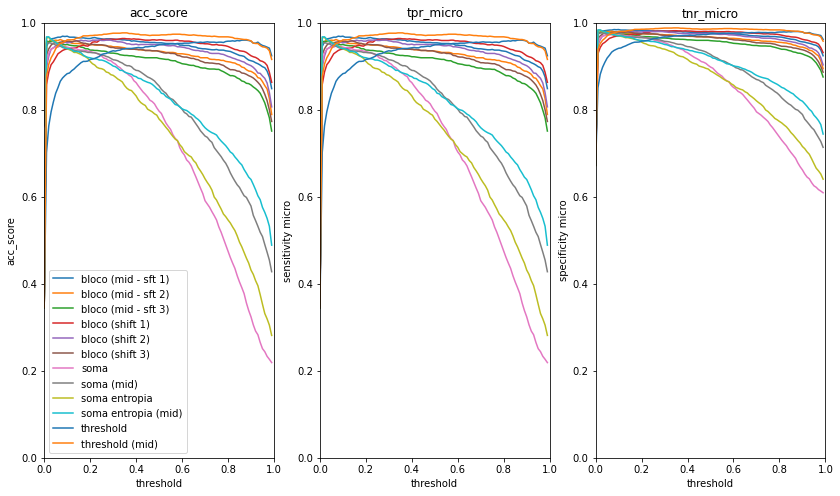

In [7]:
import matplotlib.pyplot as plt

model_name = '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S'

grouped = metrics_df[metrics_df['model_name'] == model_name].groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 3, 1)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='acc_score', label=name)
ax.set_title("acc_score")
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("acc_score")
ax.set_ylim(0.0, 1.0)

ax = plt.subplot(1, 3, 2)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_micro', label=name, legend=False)
ax.set_title("tpr_micro")
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("sensitivity micro")
ax.set_ylim(0.0, 1.0)

ax = plt.subplot(1, 3, 3)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_micro', label=name, legend=False)
ax.set_title("tnr_micro")
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("specificity micro")
ax.set_ylim(0.0, 1.0)
plt.show()

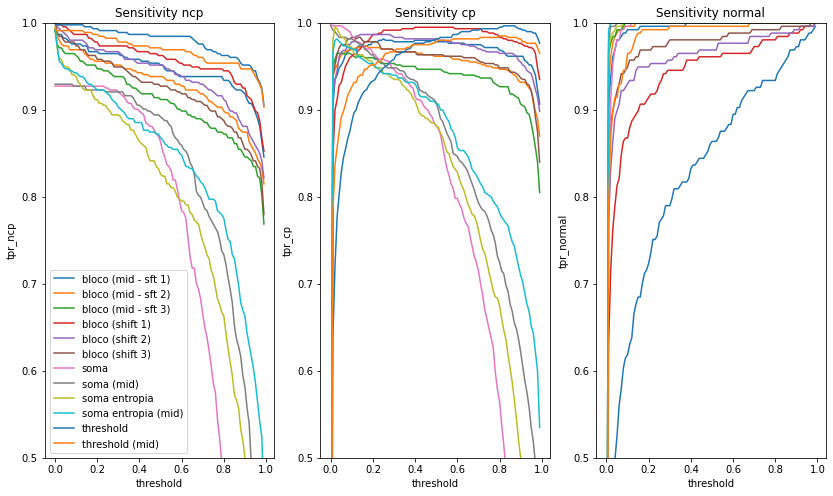

In [7]:
import matplotlib.pyplot as plt

model_name = '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S'
grouped = metrics_df[metrics_df['model_name'] == model_name].groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 3, 1)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_ncp', label=name)
ax.set_title("Sensitivity ncp")
ax.set_ylabel("tpr_ncp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 2)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_cp', label=name, legend=False)
ax.set_title("Sensitivity cp")
ax.set_ylabel("tpr_cp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 3)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tpr_normal', label=name, legend=False)
ax.set_title("Sensitivity normal")
ax.set_ylabel("tpr_normal")
ax.set_ylim(0.5, 1.0)
plt.show()

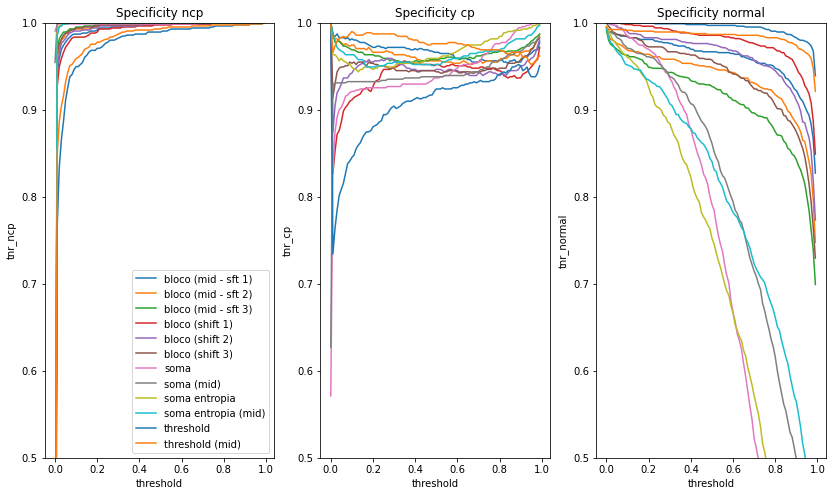

In [29]:
import matplotlib.pyplot as plt

model_name = '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S'
grouped = metrics_df[metrics_df['model_name'] == model_name].groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 3, 1)
# fig, ax = plt.subplots(figsize=(8,6))
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_ncp', label=name)
ax.set_title("Specificity ncp")
ax.set_ylabel("tnr_ncp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 2)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_cp', label=name, legend=False)
ax.set_title("Specificity cp")
ax.set_ylabel("tnr_cp")
ax.set_ylim(0.5, 1.0)


ax = plt.subplot(1, 3, 3)
for i, (name, g) in enumerate(grouped):
    g.plot(ax=ax, x='threshold', y='tnr_normal', label=name, legend=False)
ax.set_title("Specificity normal")
ax.set_ylabel("tnr_normal")
ax.set_ylim(0.5, 1.0)
plt.show()

# Roc Curve

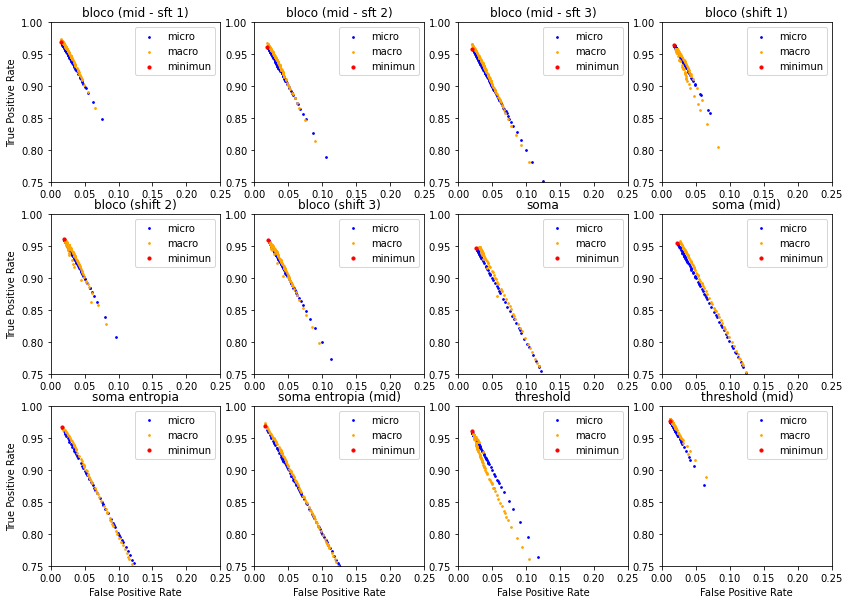

In [30]:
import matplotlib.pyplot as plt


model_name = '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S'
grouped = metrics_df[metrics_df['model_name'] == model_name].groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 10))

# fig, ax = plt.subplots(figsize=(8,6))
for i, (name, g) in enumerate(grouped, start=1):
    ax = plt.subplot(3, 4, i)
    argmin = g['dist'].argmin()
    # g.iloc[argmin] generate series, to generate single row dataframe
    min_point = g.iloc[[argmin]]
#     ncpmx, ncpmy = g['fpr_ncp'].max(), g['tpr_ncp'].max()
#     cpmx, cpmy = g['fpr_cp'].max(), g['tpr_cp'].max()
#     normalmx, normalmy = g['fpr_normal'].max(), g['tpr_normal'].max()
#     g.plot.scatter(ax = ax, x=ncpmx, y=ncpmx, label="NCP", color='blue', s=1)
#     g.plot.scatter(ax = ax, x=cpmx, y=cpmx, label="CP", color='orange', s=1)
#     g.plot.scatter(ax = ax, x=normalmx, y=normalmx, label="Normal", color='green', s=1)
    g.plot.scatter(ax=ax, x='fpr_micro', y='tpr_micro',
                   label="micro", color='blue', s=3)
    g.plot.scatter(ax=ax, x='fpr_macro', y='tpr_macro',
                   label="macro", color='orange', s=3)
    min_point.plot.scatter(ax=ax, x='fpr_micro',
                           y='tpr_micro', label="minimun", color='red', s=10)

#     g.plot.scatter(ax = ax, x='fpr_ncp', y='tpr_ncp', label="NCP", color='blue', s=1)
#     g.plot.scatter(ax = ax, x='fpr_cp', y='tpr_cp', label="CP", color='orange', s=1)
#     g.plot.scatter(ax = ax, x='fpr_normal', y='tpr_normal', label="Normal", color='green', s=1)
    ax.set_title(name)
    ax.set_xlim(0.0, 0.25)
    ax.set_ylim(0.75, 1.0)
    if i >= 9:
        ax.set_xlabel("False Positive Rate")
    else:
        ax.set_xlabel("")
    if (i % 4) == 1:
        ax.set_ylabel("True Positive Rate")
    else:
        ax.set_ylabel("")

In [33]:
from IPython.display import HTML, display
import tabulate

_df = metrics_df.iloc[metrics_df.groupby('metric')["dist"].idxmin()]
_df1 = metrics_df.iloc[metrics_df.groupby('metric')["acc_score"].idxmax()]
_df2 = metrics_df.iloc[metrics_df.groupby('metric')["tnr_ncp"].idxmax()]
table = [[x, y, z, w, x1, y1, z1, x2, y2, z2] for x, y, z, w, x1, y1, z1, x2, y2, z2 in zip(_df['metric'], _df['threshold'], _df['acc_score'], _df['dist'],
                                                                                            _df1['metric'], _df1['threshold'], _df1['acc_score'],
                                                                                            _df2['metric'], _df2['threshold'], _df2['tnr_micro'])]

display(HTML(tabulate.tabulate(table, headers=["Metric", "Threshold", "acc_score", "dist",
                                               "Metric", "Threshold", "acc_score_max",
                                               "Metric", "Threshold", "tnr_ncp_max"], tablefmt='html')))

In [32]:
metrics_df[metrics_df['metric'] ==
           'bloco (mid - sft 1)'][['threshold', 'acc_score', 'tnr_micro']]

threshold  acc_score  tnr_micro
6          0.00   0.344775   0.672387
18         0.01   0.932876   0.966438
30         0.02   0.953471   0.976735
42         0.03   0.960336   0.980168
54         0.04   0.964150   0.982075
66         0.05   0.967963   0.983982
78         0.06   0.969489   0.984744
90         0.07   0.972540   0.986270
102        0.08   0.974066   0.987033
114        0.09   0.975591   0.987796
126        0.10   0.976354   0.988177
138        0.11   0.976354   0.988177
150        0.12   0.975591   0.987796
162        0.13   0.977117   0.988558
174        0.14   0.977117   0.988558
186        0.15   0.977117   0.988558
198        0.16   0.975591   0.987796
210        0.17   0.975591   0.987796
222        0.18   0.976354   0.988177
234        0.19   0.976354   0.988177
246        0.20   0.977879   0.988940
258        0.21   0.977117   0.988558
270        0.22   0.977117   0.988558
282        0.23   0.977879   0.988940
294        0.24   0.977879   0.988940
306        0.25   0.978642   0.989321
318        0.26   0.977879   0.988940
330        0.27   0.977879   0.988940
342        0.28   0.977879   0.988940
354        0.29   0.977879   0.988940
366        0.30   0.977117   0.988558
378        0.31   0.976354   0.988177
390        0.32   0.976354   0.988177
402        0.33   0.975591   0.987796
414        0.34   0.975591   0.987796
426        0.35   0.974828   0.987414
438        0.36   0.974828   0.987414
450        0.37   0.974828   0.987414
462        0.38   0.975591   0.987796
474        0.39   0.975591   0.987796
486        0.40   0.976354   0.988177
498        0.41   0.975591   0.987796
510        0.42   0.975591   0.987796
522        0.43   0.975591   0.987796
534        0.44   0.975591   0.987796
546        0.45   0.974828   0.987414
558        0.46   0.974828   0.987414
570        0.47   0.974828   0.987414
582        0.48   0.974828   0.987414
594        0.49   0.974828   0.987414
606        0.50   0.973303   0.986651
618        0.51   0.973303   0.986651
630        0.52   0.971777   0.985889
642        0.53   0.971014   0.985507
654        0.54   0.971014   0.985507
666        0.55   0.971014   0.985507
678        0.56   0.970252   0.985126
690        0.57   0.969489   0.984744
702        0.58   0.968726   0.984363
714        0.59   0.967963   0.983982
726        0.60   0.967963   0.983982
738        0.61   0.967963   0.983982
750        0.62   0.967963   0.983982
762        0.63   0.967963   0.983982
774        0.64   0.967201   0.983600
786        0.65   0.967201   0.983600
798        0.66   0.967201   0.983600
810        0.67   0.967201   0.983600
822        0.68   0.967201   0.983600
834        0.69   0.967201   0.983600
846        0.70   0.967201   0.983600
858        0.71   0.967201   0.983600
870        0.72   0.966438   0.983219
882        0.73   0.965675   0.982838
894        0.74   0.965675   0.982838
906        0.75   0.965675   0.982838
918        0.76   0.965675   0.982838
930        0.77   0.965675   0.982838
942        0.78   0.965675   0.982838
954        0.79   0.965675   0.982838
966        0.80   0.962624   0.981312
978        0.81   0.962624   0.981312
990        0.82   0.961861   0.980931
1002       0.83   0.959573   0.979786
1014       0.84   0.957285   0.978642
1026       0.85   0.956522   0.978261
1038       0.86   0.955759   0.977879
1050       0.87   0.955759   0.977879
1062       0.88   0.955759   0.977879
1074       0.89   0.954996   0.977498
1086       0.90   0.954233   0.977117
1098       0.91   0.951945   0.975973
1110       0.92   0.948131   0.974066
1122       0.93   0.947368   0.973684
1134       0.94   0.944317   0.972159
1146       0.95   0.942029   0.971014
1158       0.96   0.937452   0.968726
1170       0.97   0.931350   0.965675
1182       0.98   0.917620   0.958810
1194       0.99   0.903890   0.951945

In [42]:
metrics_df[(metrics_df['model_name'] == model_name) & (
    metrics_df['metric'] == 'threshold')][['tpr_cp', 'fpr_cp']]

tpr_cp    fpr_cp
3     0.000000  0.000000
15    0.681667  0.265823
27    0.778333  0.236287
39    0.820000  0.215190
51    0.846667  0.198312
63    0.878333  0.191280
75    0.898333  0.184248
87    0.916667  0.172996
99    0.920000  0.161744
111   0.928333  0.158931
123   0.933333  0.154712
135   0.933333  0.151899
147   0.936667  0.144866
159   0.940000  0.140647
171   0.946667  0.137834
183   0.950000  0.132208
195   0.953333  0.127989
207   0.956667  0.125176
219   0.956667  0.125176
231   0.956667  0.123769
243   0.960000  0.119550
255   0.960000  0.118143
267   0.961667  0.116737
279   0.965000  0.113924
291   0.968333  0.112518
303   0.970000  0.105485
315   0.973333  0.105485
327   0.973333  0.104079
339   0.973333  0.099859
351   0.975000  0.097046
363   0.976667  0.095640
375   0.978333  0.098453
387   0.980000  0.097046
399   0.980000  0.095640
411   0.981667  0.092827
423   0.981667  0.091421
435   0.981667  0.090014
447   0.981667  0.090014
459   0.983333  0.090014
471   0.983333  0.088608
483   0.983333  0.087201
495   0.983333  0.085795
507   0.983333  0.087201
519   0.983333  0.087201
531   0.986667  0.085795
543   0.986667  0.085795
555   0.986667  0.084388
567   0.986667  0.082982
579   0.986667  0.082982
591   0.986667  0.078762
603   0.986667  0.075949
615   0.988333  0.075949
627   0.988333  0.075949
639   0.988333  0.074543
651   0.990000  0.075949
663   0.991667  0.075949
675   0.991667  0.075949
687   0.991667  0.075949
699   0.991667  0.074543
711   0.991667  0.074543
723   0.991667  0.074543
735   0.991667  0.073136
747   0.990000  0.071730
759   0.990000  0.071730
771   0.990000  0.070323
783   0.991667  0.070323
795   0.991667  0.068917
807   0.991667  0.068917
819   0.991667  0.067511
831   0.991667  0.068917
843   0.991667  0.067511
855   0.991667  0.066104
867   0.991667  0.067511
879   0.991667  0.067511
891   0.991667  0.067511
903   0.990000  0.067511
915   0.990000  0.066104
927   0.990000  0.066104
939   0.990000  0.064698
951   0.990000  0.060478
963   0.990000  0.059072
975   0.990000  0.057665
987   0.990000  0.056259
999   0.990000  0.057665
1011  0.990000  0.054852
1023  0.988333  0.054852
1035  0.988333  0.050633
1047  0.988333  0.050633
1059  0.986667  0.049226
1071  0.986667  0.047820
1083  0.986667  0.049226
1095  0.985000  0.054852
1107  0.985000  0.053446
1119  0.986667  0.050633
1131  0.985000  0.057665
1143  0.985000  0.061885
1155  0.985000  0.061885
1167  0.985000  0.061885
1179  0.981667  0.057665
1191  0.975000  0.049226

# Acc, sensitivity, specificity

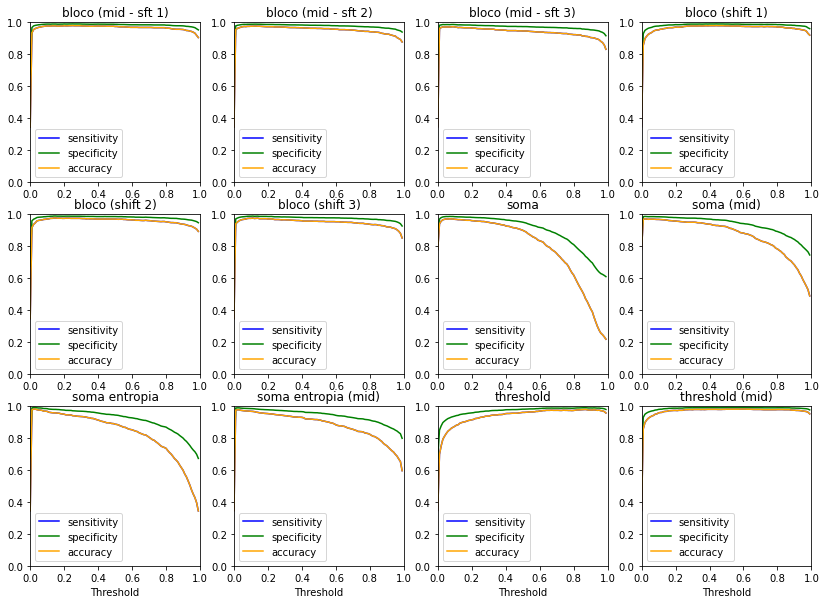

In [10]:
import matplotlib.pyplot as plt

grouped = metrics_df.groupby('metric')

# acc_score
f = plt.figure(figsize=(14, 10))

# fig, ax = plt.subplots(figsize=(8,6))
for i, (name, g) in enumerate(grouped, start=1):
    ax = plt.subplot(3, 4, i)
    g.plot(ax=ax, x='threshold', y='tpr_micro',
           label="sensitivity", color='blue')
    g.plot(ax=ax, x='threshold', y='tnr_micro',
           label="specificity", color='green')
    g.plot(ax=ax, x='threshold', y='acc_score',
           label="accuracy", color='orange')

#     g.plot(ax = ax, x='threshold', y='tpr_ncp', label="NCP", color='blue')
#     g.plot(ax = ax, x='threshold', y='tpr_cp', label="CP", color='orange')
#     g.plot(ax = ax, x='threshold', y='tpr_normal', label="Normal", color='green')
#     g.plot(ax = ax, x='threshold', y='acc_score', label="Accuracy", color='purple')
    ax.set_title(name)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    if i >= 9:
        ax.set_xlabel("Threshold")
    else:
        ax.set_xlabel("")
    if (i % 4) == 1:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")

# Validação

In [35]:
# loading predictions from feather file (processed in another notebook)
p = pathlib.Path("./predictions_all_info.feather")
if p.is_file():
    df = pd.read_feather(p)
else:
    df = pd.DataFrame()

In [23]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix


def classify_valid_threshold(df, threshold=0.5, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    new_df = df.sort_values(
        by=['files'], ascending=True).reset_index(drop=True)
    values = new_df['prob_NCP']
    slices = values.gt(threshold)
    if slices.any():
        return 'NCP'
    values = new_df['prob_CP']
    slices = values.gt(threshold)
    if slices.any():
        return 'CP'
    return 'Normal'


def classify_valid_block(df, threshold=0.5, shift=1, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    new_df = df.sort_values(
        by=['files'], ascending=True).reset_index(drop=True)
    values = new_df['prob_NCP']
    values_cut = values.gt(threshold)
    if shift == 2:
        slices = values_cut & values_cut.shift(
            1) & values_cut.shift(-1) & values_cut.shift(2) & values_cut.shift(-2)
    elif shift == 3:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1) & values_cut.shift(
            2) & values_cut.shift(-2) & values_cut.shift(3) & values_cut.shift(-3)
    else:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
    slices.fillna(False, inplace=True)
    if slices.any():
        return 'NCP'
    values = new_df['prob_CP']
    values_cut = values.gt(threshold)
    if shift == 2:
        slices = values_cut & values_cut.shift(
            1) & values_cut.shift(-1) & values_cut.shift(2) & values_cut.shift(-2)
    elif shift == 3:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1) & values_cut.shift(
            2) & values_cut.shift(-2) & values_cut.shift(3) & values_cut.shift(-3)
    else:
        slices = values_cut & values_cut.shift(1) & values_cut.shift(-1)
    slices.fillna(False, inplace=True)
    if slices.any():
        return 'CP'
    return 'Normal'


def classify_sum_percentage(df, threshold=0.5, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    sum_ncp = df['prob_NCP'].sum()
    sum_cp = df['prob_CP'].sum()
    sum_normal = df['prob_Normal'].sum()
    total = sum_ncp + sum_cp + sum_normal
    if (sum_ncp + sum_cp) / total > threshold:
        if sum_ncp >= sum_cp:
            return 'NCP'
        else:
            return 'CP'
    return 'Normal'


def classify_small_entropy_slices(df, threshold=0.5, lung_part=None):
    if lung_part is not None:
        df = df[df['pred_lungclass'] == lung_part]
    new_df = df
    values = -(((new_df['prob_NCP']*np.log2(new_df['prob_NCP'])) +
               (new_df['prob_CP']*np.log2(new_df['prob_CP'])) +
               (new_df['prob_Normal']*np.log2(new_df['prob_Normal']))) / np.log2(3))
    values_cut = values.lt(0.3)
    sum_ncp = (df['prob_NCP'] * values_cut.astype(int)).sum()
    sum_cp = (df['prob_CP'] * values_cut.astype(int)).sum()
    sum_normal = (df['prob_Normal'] * values_cut.astype(int)).sum()
    total = sum_ncp + sum_cp + sum_normal
    if sum_ncp / total > threshold:
        return 'NCP'
    if sum_cp / total > threshold:
        return 'CP'
    return 'Normal'


def metric_to_df(df, model_name, metric_name, prediction, observation, threshold=0.5):
    result = [model_name, metric_name, threshold]
    acc_score = accuracy_score(observation, prediction)
    result.extend([acc_score])
    cnf_matrix = multilabel_confusion_matrix(
        observation, prediction, labels=['NCP', 'CP', 'Normal'])
    result.extend(cnf_matrix.ravel())

    series = pd. Series(result, index=df.columns)
    df = df.append(series, ignore_index=True)

    return df

In [39]:
# dataframe to store metrics evaluation results
metrics_df_val = pd.DataFrame(columns=["model_name", "metric", "threshold", "acc_score",
                                       "tn_ncp", "fp_ncp", "fn_ncp", "tp_ncp",
                                       "tn_cp", "fp_cp", "fn_cp", "tp_cp",
                                       "tn_normal", "fp_normal", "fn_normal", "tp_normal"
                                       ])

# models = ['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L',
#           '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S']
models = ['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L']
for model_name in models:
    new_df = df[(df['model'] == model_name)]
    labels = []
    block_result = []
    threshold_result = []
    sum_percent_result = []
    small_entropy_result = []
    # loop throught all exams, each exam (g) contains # slices
    for i, ((d, l, s), g) in enumerate(new_df.groupby(['dataset', 'label', 'new_split_class'])):
        if s == 'val':
            #print("dataset={}, label={}, split_class={}, dataframe={}".format(d, l, s, g.shape))
            # labels store exam truth condition (NCP, CP, Normal)
            labels.append(l)
            # metrics calculation for each exam
            res1 = classify_valid_block(g, threshold=0.44, shift=1)
            res2 = classify_valid_threshold(
                g, threshold=0.58, lung_part='middle_lung')
            res3 = classify_sum_percentage(g, threshold=0.07)
            res4 = classify_small_entropy_slices(g, threshold=0.02)
            # storing results
            block_result.append(res1)
            threshold_result.append(res2)
            sum_percent_result.append(res3)
            small_entropy_result.append(res4)

    results = [('bloco (shift 1)', 0.44, block_result),
               ('soma', 0.07, sum_percent_result),
               ('soma entropia', 0.02, small_entropy_result),
               ('threshold (mid)', 0.58, threshold_result),
               ]
    for name, t, result in results:
        metrics_df_val = metric_to_df(
            metrics_df_val, model_name, name, result, labels, threshold=t)

In [24]:
metrics_df_val = add_metrics(metrics_df_val)

NameError: name 'metrics_df_val' is not defined

In [40]:
metrics_df_val

model_name           metric  \
0  /misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L  bloco (shift 1)   
1  /misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L             soma   
2  /misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L    soma entropia   
3  /misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L  threshold (mid)   

   threshold  acc_score tn_ncp fp_ncp fn_ncp tp_ncp tn_cp fp_cp fn_cp tp_cp  \
0       0.44   0.976909    366      2      4    191   298     8     5   252   
1       0.07   0.975133    368      0     12    183   294    12     2   255   
2       0.02   0.984014    366      2      4    191   302     4     5   252   
3       0.58   0.982238    366      2      3    192   305     1     7   250   

  tn_normal fp_normal fn_normal tp_normal  
0       449         3         4       107  
1       450         2         0       111  
2       449         3         0       111  
3       445         7         0       111

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

results = [('dummy uniforme', dummy_uni_pred),
           ('dummy mais frequente', dummy_most_pred),
           ('dummy dist. entrada', dummy_strat_pred),
           ('heuristica bloco', block_result),
           ('heuristica threshold', threshold_result),
           ('heuristica soma', sum_percent_result),
           ('heuristica soma entropia', small_entropy_result),
           ('heuristica bloco (mid)', block_midllelung_result),
           ('heuristica threshold (mid)', threshold_midllelung_result),
           ('heuristica soma (mid)', sum_percent_midllelung_result),
           ('heuristica soma entropia (mid)', small_entropy_midllelung_result)
           ]

for name, result in results:
    print("acurácia {:<30}= {:0.2f}".format(
        name, accuracy_score(labels, result)))

acurácia dummy uniforme                = 0.31
acurácia dummy mais frequente          = 0.49
acurácia dummy dist. entrada           = 0.38
acurácia heuristica bloco              = 0.49
acurácia heuristica threshold          = 0.93
acurácia heuristica soma               = 0.90
acurácia heuristica soma entropia      = 0.85
acurácia heuristica bloco (mid)        = 0.49
acurácia heuristica threshold (mid)    = 0.96
acurácia heuristica soma (mid)         = 0.92
acurácia heuristica soma entropia (mid)= 0.89


In [22]:
print(classification_report(labels, block_result))

              precision    recall  f1-score   support

          CP       0.00      0.00      0.00       246
         NCP       0.95      0.96      0.96       156
      Normal       0.28      1.00      0.44        97

    accuracy                           0.49       499
   macro avg       0.41      0.65      0.47       499
weighted avg       0.35      0.49      0.38       499



/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print(classification_report(labels, results[0][1]))

              precision    recall  f1-score   support

          CP       0.46      0.28      0.35       246
         NCP       0.30      0.32      0.31       156
      Normal       0.20      0.38      0.26        97

    accuracy                           0.31       499
   macro avg       0.32      0.33      0.31       499
weighted avg       0.36      0.31      0.32       499

